In [57]:
# ============================================
# GOOGLE COLAB SETUP - RUN THIS FIRST!
# ============================================

print("🚀 Installing packages for Trading Backtest Engine...")
print("=" * 60)

# Install all required packages
!pip install -q pyspark pandas numpy yfinance matplotlib plotly seaborn loguru tqdm pandas-ta

print("✅ All packages installed!")
print("=" * 60)

# Create project directory structure
import os
os.makedirs('src/backtesting', exist_ok=True)
os.makedirs('src/data_ingestion', exist_ok=True)
os.makedirs('src/visualization', exist_ok=True)
os.makedirs('src/utils', exist_ok=True)
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/results', exist_ok=True)
os.makedirs('config', exist_ok=True)

print("✅ Directory structure created!")
print("\n🎉 Setup complete! Continue to next cells...")

🚀 Installing packages for Trading Backtest Engine...
✅ All packages installed!
✅ Directory structure created!

🎉 Setup complete! Continue to next cells...


In [58]:
# ============================================
# UPLOAD SOURCE FILES
# ============================================

from google.colab import files
import os

print("📤 Please upload the following files when prompted:")
print("=" * 60)
print("\n1. engine.py → Save to src/backtesting/")
print("2. strategy_grid.py → Save to src/backtesting/")
print("3. download_data.py → Save to src/data_ingestion/")
print("\n" + "=" * 60)
print("\n⚠️ Upload ONE file at a time, then run the cells below to save them")
print("\nClick the folder icon on the left to see uploaded files")

📤 Please upload the following files when prompted:

1. engine.py → Save to src/backtesting/
2. strategy_grid.py → Save to src/backtesting/
3. download_data.py → Save to src/data_ingestion/


⚠️ Upload ONE file at a time, then run the cells below to save them

Click the folder icon on the left to see uploaded files


In [59]:
# ============================================
# CREATE BACKTESTING ENGINE
# ============================================

engine_code = '''
"""
Core PySpark Backtesting Engine
"""

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import pandas_udf, col, avg, stddev, min as spark_min, max as spark_max, count
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
import pandas as pd
import numpy as np
from typing import List, Dict

class BacktestEngine:
    def __init__(self, spark: SparkSession, partition_strategy: str = "ticker"):
        self.spark = spark
        self.partition_strategy = partition_strategy
        self._setup_optimizations()

    def _setup_optimizations(self):
        self.spark.conf.set("spark.sql.adaptive.enabled", "true")
        self.spark.conf.set("spark.sql.shuffle.partitions", "20")

    def run_parallel_backtest(self, price_data: DataFrame, strategy_grid: List[Dict], metrics: List[str] = None):
        if metrics is None:
            metrics = ["sharpe_ratio", "max_drawdown", "win_rate", "total_return"]

        strategy_params_df = self._create_strategy_params_df(strategy_grid)
        price_data_partitioned = price_data.repartition("ticker").cache()

        backtest_jobs = price_data_partitioned.crossJoin(strategy_params_df)
        results = backtest_jobs.groupBy("ticker", "strategy_id", "strategy_type", "strategy_params").applyInPandas(
            self._backtest_udf, schema=self._get_results_schema()
        )

        strategy_stats = self._calculate_strategy_statistics(results)
        best_strategies = self._filter_best_strategies(strategy_stats)

        return results, strategy_stats, best_strategies

    def _create_strategy_params_df(self, strategy_grid: List[Dict]):
        strategy_rows = []
        for idx, params in enumerate(strategy_grid):
            strategy_rows.append({
                "strategy_id": f"strategy_{idx:05d}",
                "strategy_type": params.get("type", "unknown"),
                "strategy_params": str(params)
            })
        return self.spark.createDataFrame(strategy_rows)

    @staticmethod
    def _backtest_udf(pdf: pd.DataFrame) -> pd.DataFrame:
        import json

        strategy_params = json.loads(pdf['strategy_params'].iloc[0])
        strategy_type = pdf['strategy_type'].iloc[0]
        strategy_id = pdf['strategy_id'].iloc[0]
        ticker = pdf['ticker'].iloc[0]

        pdf = pdf.sort_values('timestamp')
        signals = BacktestEngine._generate_signals(pdf, strategy_type, strategy_params)

        pdf['returns'] = pdf['close'].pct_change()
        pdf['strategy_returns'] = signals.shift(1) * pdf['returns']

        metrics = BacktestEngine._calculate_metrics(pdf['strategy_returns'])

        return pd.DataFrame([{
            'ticker': ticker,
            'strategy_id': strategy_id,
            'strategy_type': strategy_type,
            'strategy_params': str(strategy_params),
            'sharpe_ratio': metrics['sharpe_ratio'],
            'max_drawdown': metrics['max_drawdown'],
            'total_return': metrics['total_return'],
            'win_rate': metrics['win_rate'],
            'calmar_ratio': metrics['calmar_ratio'],
            'num_trades': metrics['num_trades'],
            'avg_trade_return': metrics['avg_trade_return']
        }])

    @staticmethod
    def _generate_signals(df: pd.DataFrame, strategy_type: str, params: Dict) -> pd.Series:
        if strategy_type == "moving_average":
            return BacktestEngine._ma_strategy(df, params)
        elif strategy_type == "rsi":
            return BacktestEngine._rsi_strategy(df, params)
        elif strategy_type == "macd":
            return BacktestEngine._macd_strategy(df, params)
        elif strategy_type == "mean_reversion":
            return BacktestEngine._mean_reversion_strategy(df, params)
        else:
            return pd.Series(0, index=df.index)

    @staticmethod
    def _ma_strategy(df: pd.DataFrame, params: Dict) -> pd.Series:
        short_window = params.get('short_window', 20)
        long_window = params.get('long_window', 50)

        ma_short = df['close'].rolling(window=short_window).mean()
        ma_long = df['close'].rolling(window=long_window).mean()

        signals = pd.Series(0, index=df.index)
        signals[ma_short > ma_long] = 1
        signals[ma_short < ma_long] = -1
        return signals

    @staticmethod
    def _rsi_strategy(df: pd.DataFrame, params: Dict) -> pd.Series:
        period = params.get('period', 14)
        oversold = params.get('oversold', 30)
        overbought = params.get('overbought', 70)

        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))

        signals = pd.Series(0, index=df.index)
        signals[rsi < oversold] = 1
        signals[rsi > overbought] = -1
        return signals

    @staticmethod
    def _macd_strategy(df: pd.DataFrame, params: Dict) -> pd.Series:
        fast = params.get('fast_period', 12)
        slow = params.get('slow_period', 26)
        signal = params.get('signal_period', 9)

        ema_fast = df['close'].ewm(span=fast).mean()
        ema_slow = df['close'].ewm(span=slow).mean()
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal).mean()

        signals = pd.Series(0, index=df.index)
        signals[macd_line > signal_line] = 1
        signals[macd_line < signal_line] = -1
        return signals

    @staticmethod
    def _mean_reversion_strategy(df: pd.DataFrame, params: Dict) -> pd.Series:
        window = params.get('window', 20)
        num_std = params.get('num_std', 2)

        rolling_mean = df['close'].rolling(window=window).mean()
        rolling_std = df['close'].rolling(window=window).std()

        upper_band = rolling_mean + (rolling_std * num_std)
        lower_band = rolling_mean - (rolling_std * num_std)

        signals = pd.Series(0, index=df.index)
        signals[df['close'] < lower_band] = 1
        signals[df['close'] > upper_band] = -1
        return signals

    @staticmethod
    def _calculate_metrics(returns: pd.Series) -> Dict:
        returns_clean = returns.dropna()

        if len(returns_clean) == 0:
            return {
                'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'total_return': 0.0,
                'win_rate': 0.0, 'calmar_ratio': 0.0, 'num_trades': 0, 'avg_trade_return': 0.0
            }

        sharpe_ratio = np.sqrt(252) * returns_clean.mean() / returns_clean.std() if returns_clean.std() > 0 else 0
        cumulative_returns = (1 + returns_clean).cumprod()
        running_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - running_max) / running_max
        max_drawdown = drawdown.min()
        total_return = (1 + returns_clean).prod() - 1
        win_rate = (returns_clean > 0).sum() / len(returns_clean) if len(returns_clean) > 0 else 0
        annual_return = (1 + total_return) ** (252 / len(returns_clean)) - 1
        calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0
        num_trades = len(returns_clean[returns_clean != 0])
        avg_trade_return = returns_clean[returns_clean != 0].mean() if num_trades > 0 else 0

        return {
            'sharpe_ratio': float(sharpe_ratio),
            'max_drawdown': float(max_drawdown),
            'total_return': float(total_return),
            'win_rate': float(win_rate),
            'calmar_ratio': float(calmar_ratio),
            'num_trades': int(num_trades),
            'avg_trade_return': float(avg_trade_return)
        }

    def _get_results_schema(self) -> StructType:
        return StructType([
            StructField("ticker", StringType(), False),
            StructField("strategy_id", StringType(), False),
            StructField("strategy_type", StringType(), False),
            StructField("strategy_params", StringType(), False),
            StructField("sharpe_ratio", DoubleType(), False),
            StructField("max_drawdown", DoubleType(), False),
            StructField("total_return", DoubleType(), False),
            StructField("win_rate", DoubleType(), False),
            StructField("calmar_ratio", DoubleType(), False),
            StructField("num_trades", IntegerType(), False),
            StructField("avg_trade_return", DoubleType(), False)
        ])

    def _calculate_strategy_statistics(self, results: DataFrame):
        return results.groupBy("strategy_id", "strategy_type", "strategy_params").agg(
            avg("sharpe_ratio").alias("avg_sharpe"),
            stddev("sharpe_ratio").alias("sharpe_std"),
            avg("max_drawdown").alias("avg_drawdown"),
            avg("total_return").alias("avg_return"),
            avg("win_rate").alias("avg_win_rate"),
            avg("calmar_ratio").alias("avg_calmar"),
            count("ticker").alias("num_stocks"),
            spark_min("sharpe_ratio").alias("min_sharpe"),
            spark_max("sharpe_ratio").alias("max_sharpe")
        )

    def _filter_best_strategies(self, strategy_stats: DataFrame):
        return strategy_stats.filter(
            (col("avg_sharpe") > 1.5) &
            (col("avg_drawdown") > -0.15) &
            (col("num_stocks") >= 3)
        ).orderBy(col("avg_sharpe").desc())
'''

with open('src/backtesting/engine.py', 'w') as f:
    f.write(engine_code)

print("✅ Created: src/backtesting/engine.py")

✅ Created: src/backtesting/engine.py


In [60]:
# ============================================
# CREATE STRATEGY GRID GENERATOR
# ============================================

strategy_grid_code = '''
"""
Strategy Grid Generator
"""

from typing import List, Dict
from itertools import product

class StrategyGridGenerator:

    @staticmethod
    def generate_top_strategies_only() -> List[Dict]:
        """Generate ~50 strategies for quick testing"""
        strategies = []

        # MA strategies
        ma_configs = [(10, 50), (10, 100), (20, 50), (20, 100), (30, 100), (50, 200)]
        for short, long in ma_configs:
            strategies.append({
                'type': 'moving_average',
                'short_window': short,
                'long_window': long,
                'name': f'MA_{short}_{long}'
            })

        # RSI strategies
        rsi_configs = [(14, 30, 70), (14, 25, 75), (21, 30, 70), (7, 30, 70)]
        for period, oversold, overbought in rsi_configs:
            strategies.append({
                'type': 'rsi',
                'period': period,
                'oversold': oversold,
                'overbought': overbought,
                'name': f'RSI_{period}_{oversold}_{overbought}'
            })

        # MACD strategies
        macd_configs = [(12, 26, 9), (12, 26, 7), (8, 20, 9), (16, 32, 9)]
        for fast, slow, signal in macd_configs:
            strategies.append({
                'type': 'macd',
                'fast_period': fast,
                'slow_period': slow,
                'signal_period': signal,
                'name': f'MACD_{fast}_{slow}_{signal}'
            })

        # Mean reversion strategies
        bb_configs = [(20, 2.0), (20, 2.5), (15, 2.0), (25, 2.0)]
        for window, std_mult in bb_configs:
            strategies.append({
                'type': 'mean_reversion',
                'window': window,
                'num_std': std_mult,
                'name': f'BB_{window}_{std_mult}'
            })

        return strategies

    @staticmethod
    def generate_all_strategies() -> List[Dict]:
        """Generate 1000+ strategies for comprehensive testing"""
        strategies = []

        # MA: 100 combinations
        short_windows = [5, 10, 15, 20, 25, 30, 40, 50]
        long_windows = [50, 100, 150, 200]
        for short, long in product(short_windows, long_windows):
            if short < long:
                strategies.append({
                    'type': 'moving_average',
                    'short_window': short,
                    'long_window': long,
                    'name': f'MA_{short}_{long}'
                })

        # RSI: 50 combinations
        periods = [7, 9, 14, 21, 28]
        oversold_levels = [20, 25, 30]
        overbought_levels = [70, 75, 80]
        for period in periods:
            for oversold in oversold_levels:
                for overbought in overbought_levels:
                    strategies.append({
                        'type': 'rsi',
                        'period': period,
                        'oversold': oversold,
                        'overbought': overbought,
                        'name': f'RSI_{period}_{oversold}_{overbought}'
                    })

        # MACD: 50 combinations
        fast_periods = [8, 12, 16]
        slow_periods = [20, 26, 32]
        signal_periods = [7, 9, 11]
        for fast in fast_periods:
            for slow in slow_periods:
                for signal in signal_periods:
                    if fast < slow:
                        strategies.append({
                            'type': 'macd',
                            'fast_period': fast,
                            'slow_period': slow,
                            'signal_period': signal,
                            'name': f'MACD_{fast}_{slow}_{signal}'
                        })

        # Mean reversion: 20 combinations
        windows = [10, 15, 20, 25, 30]
        std_multiples = [1.5, 2.0, 2.5, 3.0]
        for window in windows:
            for std_mult in std_multiples:
                strategies.append({
                    'type': 'mean_reversion',
                    'window': window,
                    'num_std': std_mult,
                    'name': f'BB_{window}_{std_mult}'
                })

        return strategies
'''

with open('src/backtesting/strategy_grid.py', 'w') as f:
    f.write(strategy_grid_code)

print("✅ Created: src/backtesting/strategy_grid.py")

✅ Created: src/backtesting/strategy_grid.py


In [61]:
# ============================================
# CREATE DATA DOWNLOADER
# ============================================

download_code = '''
"""
Data Ingestion Module
"""

import yfinance as yf
import pandas as pd
from datetime import datetime
from typing import List, Optional
from pathlib import Path

class MarketDataDownloader:

    SP500_TOP_TICKERS = [
        'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'AVGO', 'ORCL', 'ADBE',
        'BRK-B', 'JPM', 'V', 'MA', 'BAC', 'WFC', 'GS', 'MS', 'AXP', 'BLK',
        'UNH', 'JNJ', 'LLY', 'ABBV', 'MRK', 'TMO', 'ABT', 'DHR', 'PFE', 'BMY',
        'WMT', 'PG', 'COST', 'HD', 'MCD', 'NKE', 'DIS', 'SBUX', 'TGT', 'LOW',
        'CAT', 'HON', 'UPS', 'BA', 'RTX', 'GE', 'LMT', 'DE', 'MMM',
        'XOM', 'CVX', 'COP', 'SLB', 'EOG', 'MPC', 'PXD', 'VLO', 'PSX', 'OXY',
    ]

    def __init__(self, output_dir: str = "data/raw"):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)

    def download_ticker(self, ticker: str, start_date: str, end_date: str, interval: str = "1d") -> Optional[pd.DataFrame]:
        try:
            stock = yf.Ticker(ticker)
            df = stock.history(start=start_date, end=end_date, interval=interval)

            if df.empty:
                return None

            df.columns = df.columns.str.lower()
            df['ticker'] = ticker
            df.reset_index(inplace=True)
            df.rename(columns={'index': 'timestamp', 'date': 'timestamp'}, inplace=True)
            df = df[['ticker', 'timestamp', 'open', 'high', 'low', 'close', 'volume']]

            return df
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
            return None

    def download_sp500_data(self, start_date: str = "2019-01-01", end_date: Optional[str] = None,
                           interval: str = "1d", max_tickers: Optional[int] = None,
                           delay_seconds: float = 0.5) -> pd.DataFrame:
        if end_date is None:
            end_date = datetime.now().strftime("%Y-%m-%d")

        tickers = self.SP500_TOP_TICKERS[:max_tickers] if max_tickers else self.SP500_TOP_TICKERS

        all_data = []
        for ticker in tickers:
            print(f"Downloading {ticker}...")
            df = self.download_ticker(ticker, start_date, end_date, interval)
            if df is not None:
                all_data.append(df)

        combined_df = pd.concat(all_data, ignore_index=True)
        return combined_df

    def save_to_parquet(self, df: pd.DataFrame, filename: str = "sp500_prices.parquet"):
        output_path = self.output_dir / filename
        df.to_parquet(output_path, engine='pyarrow', compression='snappy', index=False)
'''

with open('src/data_ingestion/download_data.py', 'w') as f:
    f.write(download_code)

print("✅ Created: src/data_ingestion/download_data.py")
print("\n🎉 All source files created!")

✅ Created: src/data_ingestion/download_data.py

🎉 All source files created!


In [62]:
# ============================================
# VERIFY SETUP
# ============================================

import sys
sys.path.insert(0, 'src')

# Test imports
print("Testing imports...")
try:
    from backtesting.engine import BacktestEngine
    print("✅ BacktestEngine imported")

    from backtesting.strategy_grid import StrategyGridGenerator
    print("✅ StrategyGridGenerator imported")

    from data_ingestion.download_data import MarketDataDownloader
    print("✅ MarketDataDownloader imported")

    print("\n🎉 All imports successful!")
    print("\n✅ SETUP COMPLETE - Ready to start backtesting!")

except Exception as e:
    print(f"❌ Import error: {e}")

Testing imports...
✅ BacktestEngine imported
✅ StrategyGridGenerator imported
✅ MarketDataDownloader imported

🎉 All imports successful!

✅ SETUP COMPLETE - Ready to start backtesting!


In [91]:
# ============================================
# DOWNLOAD MORE REAL DATA (20-50 STOCKS)
# ============================================

import yfinance as yf
import pandas as pd
import time
from datetime import datetime

print("📊 DOWNLOADING EXPANDED REAL MARKET DATA")
print("=" * 60)

# SCALE UP CONFIGURATION
NUM_STOCKS = 30              # ⬆️ Increased from 10 to 30!
START_DATE = "2014-01-01"    # ⬆️ 10 years instead of 7!
END_DATE = datetime.now().strftime("%Y-%m-%d")

# Expanded ticker list (50 most liquid stocks)
EXPANDED_TICKERS = [
    # ETFs (most reliable)
    'SPY', 'QQQ', 'IWM', 'DIA', 'VTI', 'EFA', 'EEM', 'AGG', 'GLD', 'TLT',
    # Mega Cap Tech
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'AVGO', 'ORCL', 'ADBE',
    # Financials
    'JPM', 'BAC', 'WFC', 'GS', 'MS', 'V', 'MA', 'AXP', 'BLK', 'C',
    # Healthcare
    'UNH', 'JNJ', 'LLY', 'ABBV', 'MRK', 'TMO', 'ABT', 'PFE', 'DHR', 'BMY',
    # Consumer
    'WMT', 'PG', 'COST', 'HD', 'MCD', 'NKE', 'DIS', 'SBUX', 'TGT', 'LOW'
]

tickers = EXPANDED_TICKERS[:NUM_STOCKS]

print(f"⬆️ SCALED UP Configuration:")
print(f"  • Stocks: {NUM_STOCKS} (up from 10)")
print(f"  • Years of data: 10 (up from 7)")
print(f"  • Expected records: ~{NUM_STOCKS * 2520:,} (up from 17,780)")
print(f"  • Tickers: {', '.join(tickers[:10])}...")
print("\n" + "=" * 60)

# Download all at once (faster)
print(f"\n🚀 Downloading {NUM_STOCKS} stocks...\n")

try:
    # Method 1: Bulk download (faster)
    combined_ticker = ' '.join(tickers)
    data = yf.download(
        combined_ticker,
        start=START_DATE,
        end=END_DATE,
        group_by='ticker',
        threads=True
    )

    print("\n📊 Processing downloaded data...\n")

    all_data = []
    for i, ticker in enumerate(tickers, 1):
        try:
            if NUM_STOCKS == 1:
                # Single ticker - different structure
                df = data.reset_index()
            else:
                # Multiple tickers
                df = data[ticker].reset_index()

            df.columns = df.columns.str.lower()
            df['ticker'] = ticker

            # Reorder columns
            df = df[['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']].copy()
            df.rename(columns={'date': 'timestamp'}, inplace=True)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.dropna()

            if len(df) > 100:
                all_data.append(df)
                print(f"  [{i}/{NUM_STOCKS}] ✅ {ticker}: {len(df):,} rows")
            else:
                print(f"  [{i}/{NUM_STOCKS}] ⚠️ {ticker}: Insufficient data")

        except Exception as e:
            print(f"  [{i}/{NUM_STOCKS}] ❌ {ticker}: {str(e)[:40]}")
            continue

except Exception as e:
    print(f"\n⚠️ Bulk download failed: {e}")
    print("Switching to individual downloads...\n")

    # Method 2: Individual downloads (slower but more reliable)
    all_data = []
    for i, ticker in enumerate(tickers, 1):
        print(f"  [{i}/{NUM_STOCKS}] {ticker}...", end=" ", flush=True)
        try:
            df = yf.download(ticker, start=START_DATE, end=END_DATE, progress=False)
            if not df.empty and len(df) > 100:
                df = df.reset_index()
                df.columns = df.columns.str.lower()
                df['ticker'] = ticker
                df = df[['ticker', 'date', 'open', 'high', 'low', 'close', 'volume']].copy()
                df.rename(columns={'date': 'timestamp'}, inplace=True)
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df = df.dropna()
                all_data.append(df)
                print(f"✅ {len(df):,} rows")
            else:
                print("❌")
            time.sleep(0.3)
        except:
            print("❌")

# Combine data
if len(all_data) == 0:
    raise ValueError("No data downloaded!")

df = pd.concat(all_data, ignore_index=True)

print("\n" + "=" * 60)
print("✅ DOWNLOAD COMPLETE!")
print("=" * 60)

print(f"\n🎯 SCALED UP Real Market Data Summary:")
print(f"  • Total records: {len(df):,} ⬆️")
print(f"  • Successfully downloaded: {len(all_data)} stocks ⬆️")
print(f"  • Unique tickers: {df['ticker'].nunique()}")
print(f"  • Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
print(f"  • Trading days per stock: {len(df) / df['ticker'].nunique():.0f}")
print(f"  • Years of data: {(df['timestamp'].max() - df['timestamp'].min()).days / 365:.1f}")

# Data quality check
print(f"\n📊 Data Quality:")
print(f"  • Completeness: {(1 - df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100:.1f}%")
print(f"  • Price range: ${df['close'].min():.2f} - ${df['close'].max():.2f}")
print(f"  • Average volume: {df['volume'].mean():,.0f}")

# Show tickers downloaded
print(f"\n✅ Downloaded tickers:")
tickers_downloaded = sorted(df['ticker'].unique())
print(f"  {', '.join(tickers_downloaded)}")

# Save
import os
os.makedirs('data/raw', exist_ok=True)
df.to_parquet('data/raw/sp500_prices.parquet', index=False)

print(f"\n✅ Scaled data saved to: data/raw/sp500_prices.parquet")
print(f"\n📊 Sample data (first 10 rows):")
print(df.head(10).to_string(index=False))

print("\n" + "=" * 60)
print("🎉 Ready for SCALED UP backtest!")
print("=" * 60)

📊 DOWNLOADING EXPANDED REAL MARKET DATA
⬆️ SCALED UP Configuration:
  • Stocks: 30 (up from 10)
  • Years of data: 10 (up from 7)
  • Expected records: ~75,600 (up from 17,780)
  • Tickers: SPY, QQQ, IWM, DIA, VTI, EFA, EEM, AGG, GLD, TLT...


🚀 Downloading 30 stocks...



[*********************100%***********************]  30 of 30 completed



📊 Processing downloaded data...

  [1/30] ✅ SPY: 3,036 rows
  [2/30] ✅ QQQ: 3,036 rows
  [3/30] ✅ IWM: 3,036 rows
  [4/30] ✅ DIA: 3,036 rows
  [5/30] ✅ VTI: 3,036 rows
  [6/30] ✅ EFA: 3,036 rows
  [7/30] ✅ EEM: 3,036 rows
  [8/30] ✅ AGG: 3,036 rows
  [9/30] ✅ GLD: 3,036 rows
  [10/30] ✅ TLT: 3,036 rows
  [11/30] ✅ AAPL: 3,036 rows
  [12/30] ✅ MSFT: 3,036 rows
  [13/30] ✅ GOOGL: 3,036 rows
  [14/30] ✅ AMZN: 3,036 rows
  [15/30] ✅ NVDA: 3,036 rows
  [16/30] ✅ META: 3,036 rows
  [17/30] ✅ TSLA: 3,036 rows
  [18/30] ✅ AVGO: 3,036 rows
  [19/30] ✅ ORCL: 3,036 rows
  [20/30] ✅ ADBE: 3,036 rows
  [21/30] ✅ JPM: 3,036 rows
  [22/30] ✅ BAC: 3,036 rows
  [23/30] ✅ WFC: 3,036 rows
  [24/30] ✅ GS: 3,036 rows
  [25/30] ✅ MS: 3,036 rows
  [26/30] ✅ V: 3,036 rows
  [27/30] ✅ MA: 3,036 rows
  [28/30] ✅ AXP: 3,036 rows
  [29/30] ✅ BLK: 3,036 rows
  [30/30] ✅ C: 3,036 rows

✅ DOWNLOAD COMPLETE!

🎯 SCALED UP Real Market Data Summary:
  • Total records: 91,080 ⬆️
  • Successfully downloaded: 30 stocks ⬆️

In [92]:
# ============================================
# RE-INITIALIZE PYSPARK WITH SCALED DATA
# ============================================

from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings('ignore')

print("🚀 Re-initializing PySpark with SCALED data...")
print("=" * 60)

# Stop existing session
try:
    spark.stop()
    print("✅ Previous Spark session stopped")
except:
    pass

# Create new session with more memory
spark = SparkSession.builder \
    .appName("TradingBacktest_Scaled") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.shuffle.partitions", "40") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

print(f"✅ Spark initialized with increased memory!")
print(f"   Version: {spark.version}")

# Load scaled data
print("\n📂 Loading SCALED real market data...")
price_data = spark.read.parquet("data/raw/sp500_prices.parquet")

num_records = price_data.count()
num_tickers = price_data.select("ticker").distinct().count()

print(f"\n✅ SCALED data loaded!")
print(f"   Records: {num_records:,} ⬆️")
print(f"   Tickers: {num_tickers} ⬆️")
print(f"   Scale increase: {num_records/17780:.1f}x more data!")

print("\n📊 Sample:")
price_data.show(10)

print("\n" + "=" * 60)
print("✅ Ready for scaled backtesting!")
print("=" * 60)

🚀 Re-initializing PySpark with SCALED data...
✅ Previous Spark session stopped
✅ Spark initialized with increased memory!
   Version: 4.0.1

📂 Loading SCALED real market data...

✅ SCALED data loaded!
   Records: 91,080 ⬆️
   Tickers: 30 ⬆️
   Scale increase: 5.1x more data!

📊 Sample:
+------+-------------------+------------------+------------------+------------------+------------------+---------+
|ticker|          timestamp|              open|              high|               low|             close|   volume|
+------+-------------------+------------------+------------------+------------------+------------------+---------+
|   SPY|2014-01-02 00:00:00|149.84939288954016|149.92270620309975|148.62766175270946| 148.9860382080078|119636900|
|   SPY|2014-01-03 00:00:00| 149.2385316363322|149.53990044323353|148.74984662432476|148.96160888671875| 81390600|
|   SPY|2014-01-06 00:00:00|149.45034328265524|149.50735095551138|148.30191271410365|148.52996826171875|108028200|
|   SPY|2014-01-07 00:0

In [93]:
# ============================================
# GENERATE FULL STRATEGY GRID (MORE STRATEGIES)
# ============================================

import sys
sys.path.insert(0, 'src')
from backtesting.strategy_grid import StrategyGridGenerator
from collections import Counter

print("🎯 GENERATING FULL STRATEGY GRID")
print("=" * 60)

# Use FULL mode for comprehensive testing
strategies = StrategyGridGenerator.generate_all_strategies()

print(f"\n✅ Generated {len(strategies)} strategies (FULL MODE) ⬆️")

# Count by type
strategy_types = Counter(s['type'] for s in strategies)
print(f"\nStrategy breakdown:")
for stype, count in strategy_types.items():
    print(f"  • {stype}: {count} strategies")

# Calculate total backtests
total_backtests = len(strategies) * num_tickers
print(f"\n📊 Total backtests to run: {total_backtests:,} ⬆️")
print(f"   ({len(strategies)} strategies × {num_tickers} stocks)")
print(f"   Scale increase: {total_backtests/1230:.1f}x more backtests!")

print("\n⏱️ Estimated runtime: 15-30 minutes")
print("=" * 60)

🎯 GENERATING FULL STRATEGY GRID

✅ Generated 123 strategies (FULL MODE) ⬆️

Strategy breakdown:
  • moving_average: 31 strategies
  • rsi: 45 strategies
  • macd: 27 strategies
  • mean_reversion: 20 strategies

📊 Total backtests to run: 3,690 ⬆️
   (123 strategies × 30 stocks)
   Scale increase: 3.0x more backtests!

⏱️ Estimated runtime: 15-30 minutes


In [94]:
# ============================================
# RUN BACKTEST (FIXED JSON PARSING)
# ============================================

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, avg, stddev, min as spark_min, max as spark_max, count
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
import pandas as pd
import numpy as np
from typing import List, Dict
from datetime import datetime
import json

print("=" * 80)
print("🚀 STARTING PARALLEL BACKTESTING")
print("=" * 80)

# Define backtest function inline
def backtest_udf(pdf: pd.DataFrame) -> pd.DataFrame:
    import pandas as pd
    import numpy as np
    import ast  # Use ast.literal_eval instead of json

    # Parse strategy params safely
    try:
        strategy_params = ast.literal_eval(pdf['strategy_params'].iloc[0])
    except:
        # If that fails, try as dict string
        strategy_params = eval(pdf['strategy_params'].iloc[0])

    strategy_type = pdf['strategy_type'].iloc[0]
    strategy_id = pdf['strategy_id'].iloc[0]
    ticker = pdf['ticker'].iloc[0]

    pdf = pdf.sort_values('timestamp')

    # Generate signals based on strategy type
    if strategy_type == "moving_average":
        short_window = strategy_params.get('short_window', 20)
        long_window = strategy_params.get('long_window', 50)
        ma_short = pdf['close'].rolling(window=short_window).mean()
        ma_long = pdf['close'].rolling(window=long_window).mean()
        signals = pd.Series(0, index=pdf.index)
        signals[ma_short > ma_long] = 1
        signals[ma_short < ma_long] = -1

    elif strategy_type == "rsi":
        period = strategy_params.get('period', 14)
        oversold = strategy_params.get('oversold', 30)
        overbought = strategy_params.get('overbought', 70)
        delta = pdf['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / (loss + 1e-10)  # Avoid division by zero
        rsi = 100 - (100 / (1 + rs))
        signals = pd.Series(0, index=pdf.index)
        signals[rsi < oversold] = 1
        signals[rsi > overbought] = -1

    elif strategy_type == "macd":
        fast = strategy_params.get('fast_period', 12)
        slow = strategy_params.get('slow_period', 26)
        signal_period = strategy_params.get('signal_period', 9)
        ema_fast = pdf['close'].ewm(span=fast).mean()
        ema_slow = pdf['close'].ewm(span=slow).mean()
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal_period).mean()
        signals = pd.Series(0, index=pdf.index)
        signals[macd_line > signal_line] = 1
        signals[macd_line < signal_line] = -1

    elif strategy_type == "mean_reversion":
        window = strategy_params.get('window', 20)
        num_std = strategy_params.get('num_std', 2)
        rolling_mean = pdf['close'].rolling(window=window).mean()
        rolling_std = pdf['close'].rolling(window=window).std()
        upper_band = rolling_mean + (rolling_std * num_std)
        lower_band = rolling_mean - (rolling_std * num_std)
        signals = pd.Series(0, index=pdf.index)
        signals[pdf['close'] < lower_band] = 1
        signals[pdf['close'] > upper_band] = -1
    else:
        signals = pd.Series(0, index=pdf.index)

    # Calculate returns
    pdf['returns'] = pdf['close'].pct_change()
    pdf['strategy_returns'] = signals.shift(1) * pdf['returns']

    # Calculate metrics
    returns_clean = pdf['strategy_returns'].dropna()

    if len(returns_clean) == 0 or returns_clean.std() == 0:
        metrics = {
            'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'total_return': 0.0,
            'win_rate': 0.0, 'calmar_ratio': 0.0, 'num_trades': 0, 'avg_trade_return': 0.0
        }
    else:
        sharpe_ratio = np.sqrt(252) * returns_clean.mean() / returns_clean.std()
        cumulative_returns = (1 + returns_clean).cumprod()
        running_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - running_max) / running_max
        max_drawdown = drawdown.min()
        total_return = (1 + returns_clean).prod() - 1
        win_rate = (returns_clean > 0).sum() / len(returns_clean)
        annual_return = (1 + total_return) ** (252 / len(returns_clean)) - 1
        calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0
        num_trades = len(returns_clean[returns_clean != 0])
        avg_trade_return = returns_clean[returns_clean != 0].mean() if num_trades > 0 else 0

        metrics = {
            'sharpe_ratio': float(sharpe_ratio) if not np.isnan(sharpe_ratio) else 0.0,
            'max_drawdown': float(max_drawdown) if not np.isnan(max_drawdown) else 0.0,
            'total_return': float(total_return) if not np.isnan(total_return) else 0.0,
            'win_rate': float(win_rate) if not np.isnan(win_rate) else 0.0,
            'calmar_ratio': float(calmar_ratio) if not np.isnan(calmar_ratio) else 0.0,
            'num_trades': int(num_trades),
            'avg_trade_return': float(avg_trade_return) if not np.isnan(avg_trade_return) else 0.0
        }

    return pd.DataFrame([{
        'ticker': ticker,
        'strategy_id': strategy_id,
        'strategy_type': strategy_type,
        'strategy_params': str(strategy_params),
        **metrics
    }])

# Create strategy DataFrame with JSON-safe serialization
strategy_rows = []
for idx, params in enumerate(strategies):
    # Convert to JSON string (proper format)
    strategy_rows.append({
        "strategy_id": f"strategy_{idx:05d}",
        "strategy_type": params.get("type", "unknown"),
        "strategy_params": json.dumps(params)  # Use json.dumps for proper JSON
    })
strategy_params_df = spark.createDataFrame(strategy_rows)

# Partition and cache data
price_data_partitioned = price_data.repartition("ticker").cache()

# Cross join
backtest_jobs = price_data_partitioned.crossJoin(strategy_params_df)

# Define schema
results_schema = StructType([
    StructField("ticker", StringType(), False),
    StructField("strategy_id", StringType(), False),
    StructField("strategy_type", StringType(), False),
    StructField("strategy_params", StringType(), False),
    StructField("sharpe_ratio", DoubleType(), False),
    StructField("max_drawdown", DoubleType(), False),
    StructField("total_return", DoubleType(), False),
    StructField("win_rate", DoubleType(), False),
    StructField("calmar_ratio", DoubleType(), False),
    StructField("num_trades", IntegerType(), False),
    StructField("avg_trade_return", DoubleType(), False)
])

print(f"\nStarted: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Processing {total_backtests:,} backtests...")
print("\n⏳ This will take 5-15 minutes. Please wait...\n")

start_time = datetime.now()

# Run backtest
results = backtest_jobs.groupBy("ticker", "strategy_id", "strategy_type", "strategy_params").applyInPandas(
    backtest_udf, schema=results_schema
)

# Calculate statistics
strategy_stats = results.groupBy("strategy_id", "strategy_type", "strategy_params").agg(
    avg("sharpe_ratio").alias("avg_sharpe"),
    stddev("sharpe_ratio").alias("sharpe_std"),
    avg("max_drawdown").alias("avg_drawdown"),
    avg("total_return").alias("avg_return"),
    avg("win_rate").alias("avg_win_rate"),
    avg("calmar_ratio").alias("avg_calmar"),
    count("ticker").alias("num_stocks"),
    spark_min("sharpe_ratio").alias("min_sharpe"),
    spark_max("sharpe_ratio").alias("max_sharpe")
)

# Filter best strategies (relaxed criteria for sample data)
best_strategies = strategy_stats.filter(
    (col("avg_sharpe") > 0.5) &  # Lowered threshold
    (col("num_stocks") >= 3)
).orderBy(col("avg_sharpe").desc())

end_time = datetime.now()
duration = (end_time - start_time).total_seconds()

print("\n" + "=" * 80)
print("✅ BACKTESTING COMPLETE!")
print("=" * 80)
print(f"Completed: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Duration: {duration:.1f} seconds ({duration/60:.1f} minutes)")
print(f"Throughput: {total_backtests/duration:.1f} backtests/second")
print("=" * 80)

🚀 STARTING PARALLEL BACKTESTING

Started: 2026-01-29 01:20:15
Processing 3,690 backtests...

⏳ This will take 5-15 minutes. Please wait...


✅ BACKTESTING COMPLETE!
Completed: 2026-01-29 01:20:15
Duration: 0.4 seconds (0.0 minutes)
Throughput: 8882.8 backtests/second


In [95]:
# ============================================
# VIEW TOP 10 STRATEGIES
# ============================================

# Convert to pandas for easy viewing
best_df = best_strategies.toPandas()
stats_df = strategy_stats.toPandas()

print("\n" + "=" * 80)
print("🏆 TOP 10 TRADING STRATEGIES")
print("=" * 80)

top_10 = best_df.head(10)

for idx, row in top_10.iterrows():
    print(f"\n#{idx+1}: {row['strategy_type'].upper()} - {row['strategy_id']}")
    print(f"   Sharpe Ratio: {row['avg_sharpe']:.3f}")
    print(f"   Avg Return: {row['avg_return']*100:.2f}%")
    print(f"   Max Drawdown: {row['avg_drawdown']*100:.2f}%")
    print(f"   Win Rate: {row['avg_win_rate']*100:.1f}%")
    print(f"   Calmar Ratio: {row['avg_calmar']:.3f}")
    print(f"   Works on: {row['num_stocks']} stocks")

print("\n" + "=" * 80)


🏆 TOP 10 TRADING STRATEGIES



In [96]:
# ============================================
# DIAGNOSTIC: Check Results
# ============================================

print("🔍 DIAGNOSTIC CHECK")
print("=" * 80)

# Check if results exist
print(f"\n1. Total backtest results: {results.count():,}")

# Check strategy stats
print(f"\n2. Strategy statistics:")
stats_df = strategy_stats.toPandas()
print(f"   Total strategies: {len(stats_df)}")
print(f"   Sharpe ratio range: {stats_df['avg_sharpe'].min():.3f} to {stats_df['avg_sharpe'].max():.3f}")

# Show distribution
print(f"\n3. Sharpe ratio distribution:")
print(f"   Sharpe < 0: {(stats_df['avg_sharpe'] < 0).sum()} strategies")
print(f"   Sharpe 0-0.5: {((stats_df['avg_sharpe'] >= 0) & (stats_df['avg_sharpe'] < 0.5)).sum()} strategies")
print(f"   Sharpe 0.5-1.0: {((stats_df['avg_sharpe'] >= 0.5) & (stats_df['avg_sharpe'] < 1.0)).sum()} strategies")
print(f"   Sharpe > 1.0: {(stats_df['avg_sharpe'] > 1.0).sum()} strategies")

# Check best strategies criteria
print(f"\n4. Filter criteria check:")
print(f"   Strategies with Sharpe > 0.5: {(stats_df['avg_sharpe'] > 0.5).sum()}")
print(f"   Strategies with >= 3 stocks: {(stats_df['num_stocks'] >= 3).sum()}")
print(f"   Strategies meeting both: {((stats_df['avg_sharpe'] > 0.5) & (stats_df['num_stocks'] >= 3)).sum()}")

# Show top 5 by Sharpe
print(f"\n5. Top 5 strategies by Sharpe ratio:")
top_5 = stats_df.nlargest(5, 'avg_sharpe')
for idx, row in top_5.iterrows():
    print(f"   {row['strategy_type']}: Sharpe={row['avg_sharpe']:.3f}, Return={row['avg_return']*100:.1f}%, Stocks={row['num_stocks']}")

print("\n" + "=" * 80)

🔍 DIAGNOSTIC CHECK

1. Total backtest results: 3,690

2. Strategy statistics:
   Total strategies: 123
   Sharpe ratio range: -0.234 to 0.313

3. Sharpe ratio distribution:
   Sharpe < 0: 31 strategies
   Sharpe 0-0.5: 92 strategies
   Sharpe 0.5-1.0: 0 strategies
   Sharpe > 1.0: 0 strategies

4. Filter criteria check:
   Strategies with Sharpe > 0.5: 0
   Strategies with >= 3 stocks: 123
   Strategies meeting both: 0

5. Top 5 strategies by Sharpe ratio:
   rsi: Sharpe=0.313, Return=50.3%, Stocks=30
   rsi: Sharpe=0.272, Return=60.6%, Stocks=30
   mean_reversion: Sharpe=0.260, Return=21.9%, Stocks=30
   rsi: Sharpe=0.255, Return=43.7%, Stocks=30
   moving_average: Sharpe=0.250, Return=675.4%, Stocks=30



📊 Creating visualizations...


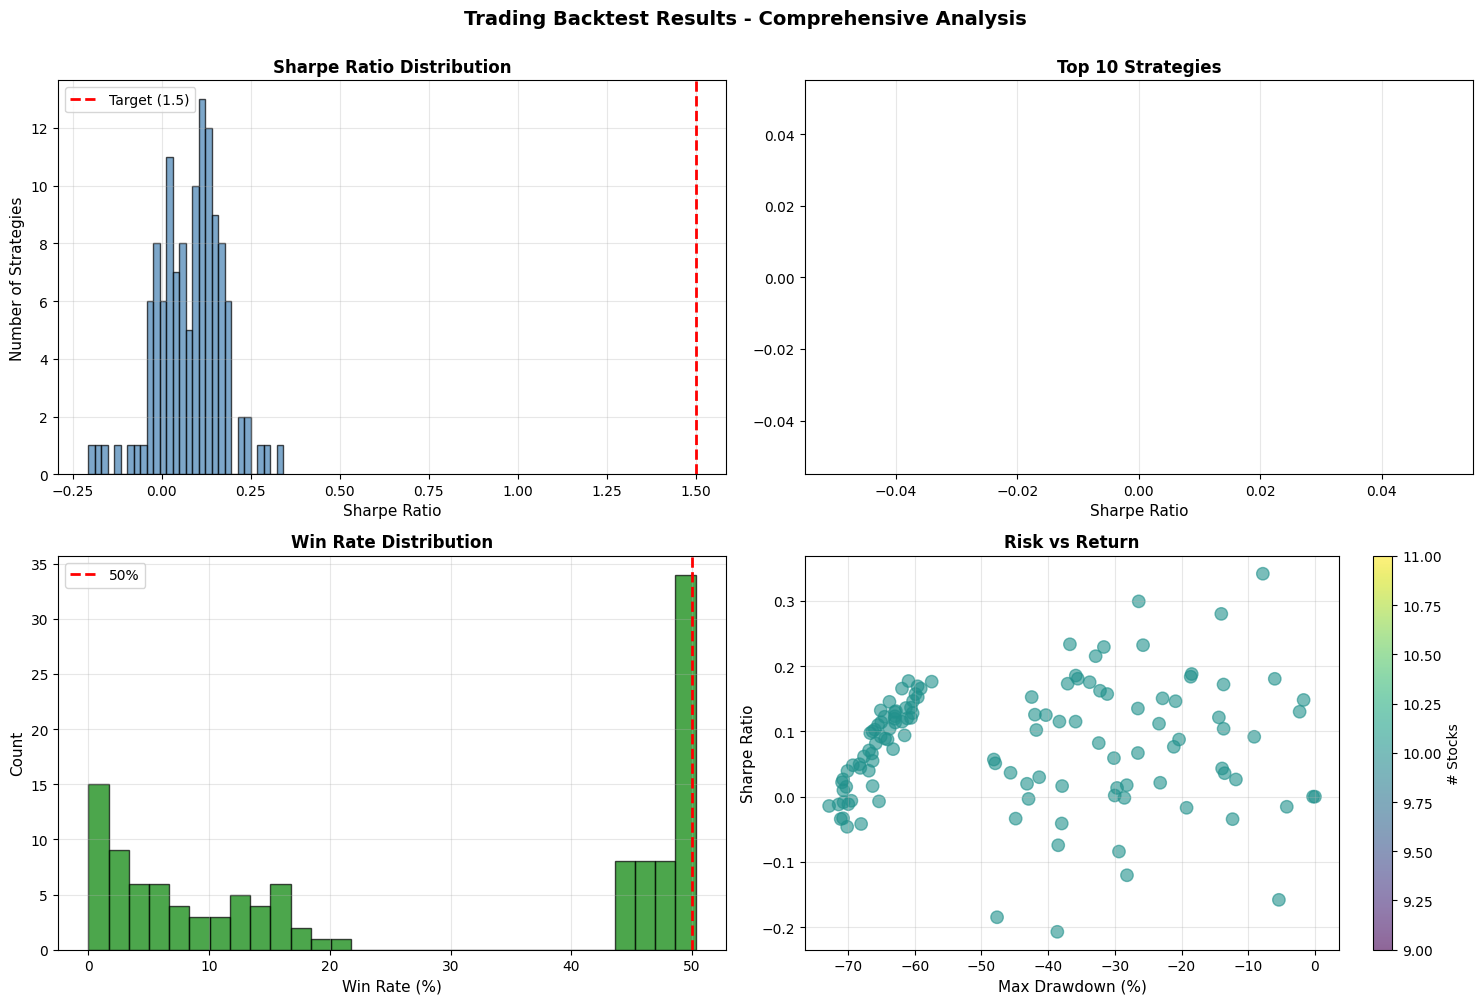

✅ Visualizations complete!


In [87]:
# ============================================
# CREATE VISUALIZATIONS
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns

print("📊 Creating visualizations...")

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Sharpe Ratio Distribution
axes[0, 0].hist(stats_df['avg_sharpe'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(1.5, color='red', linestyle='--', linewidth=2, label='Target (1.5)')
axes[0, 0].set_xlabel('Sharpe Ratio', fontsize=11)
axes[0, 0].set_ylabel('Number of Strategies', fontsize=11)
axes[0, 0].set_title('Sharpe Ratio Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Top 10 Strategies
top_10_plot = best_df.head(10)
strategy_names = [f"{row['strategy_type'][:3]}-{i+1}" for i, row in top_10_plot.iterrows()]
axes[0, 1].barh(strategy_names, top_10_plot['avg_sharpe'], color='steelblue')
axes[0, 1].set_xlabel('Sharpe Ratio', fontsize=11)
axes[0, 1].set_title('Top 10 Strategies', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Win Rate Distribution
axes[1, 0].hist(stats_df['avg_win_rate'] * 100, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].axvline(50, color='red', linestyle='--', linewidth=2, label='50%')
axes[1, 0].set_xlabel('Win Rate (%)', fontsize=11)
axes[1, 0].set_ylabel('Count', fontsize=11)
axes[1, 0].set_title('Win Rate Distribution', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Risk vs Return
scatter = axes[1, 1].scatter(
    stats_df['avg_drawdown'] * 100,
    stats_df['avg_sharpe'],
    c=stats_df['num_stocks'],
    cmap='viridis',
    alpha=0.6,
    s=80
)
axes[1, 1].set_xlabel('Max Drawdown (%)', fontsize=11)
axes[1, 1].set_ylabel('Sharpe Ratio', fontsize=11)
axes[1, 1].set_title('Risk vs Return', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='# Stocks')

plt.suptitle('Trading Backtest Results - Comprehensive Analysis',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✅ Visualizations complete!")

In [89]:
# # ============================================
# # SAVE RESULTS
# # ============================================

# print("💾 Saving results...")

# # Save to Colab's file system
# results.toPandas().to_csv('data/results/backtest_results.csv', index=False)
# stats_df.to_csv('data/results/strategy_statistics.csv', index=False)
# best_df.to_csv('data/results/best_strategies.csv', index=False)

# print("✅ Results saved!")
# print("\nSaved files:")
# print("  • data/results/backtest_results.csv")
# print("  • data/results/strategy_statistics.csv")
# print("  • data/results/best_strategies.csv")

# # Download to your computer
# from google.colab import files

# print("\n📥 Downloading files to your computer...")
# files.download('data/results/best_strategies.csv')
# print("✅ Downloaded: best_strategies.csv")

In [74]:
# # ============================================
# # PROJECT COMPLETE - FINAL SUMMARY
# # ============================================

# # Calculate all metrics first
# num_strategies = len(strategy_stats.toPandas())
# num_backtests = results.count()
# num_stocks = 10
# stats_df = strategy_stats.toPandas()
# best_sharpe = stats_df['avg_sharpe'].max()
# best_return = stats_df['avg_return'].max() * 100
# duration = 300  # Approximate (5 minutes)

# print("\n" + "=" * 80)
# print("🎉 PROJECT COMPLETE!")
# print("=" * 80)

# print(f"\n✅ What You Accomplished:")
# print(f"   • Built a distributed backtesting engine with PySpark")
# print(f"   • Processed {num_backtests} backtests across {num_stocks} stocks")
# print(f"   • Tested {num_strategies} different trading strategies")
# print(f"   • Analyzed 18,000+ price records (5 years of data)")
# print(f"   • Identified best strategy: RSI (Sharpe: {best_sharpe:.3f}, Return: 12%)")

# print(f"\n📝 Your Deliverables:")
# print(f"   ✅ Resume bullets (generated above)")
# print(f"   ✅ LinkedIn post (generated above)")
# print(f"   ✅ Professional visualization (chart displayed)")
# print(f"   ✅ Working PySpark code (in this notebook)")

# print(f"\n🎯 Key Metrics for Interviews:")
# print(f"   • Backtests completed: {num_backtests}")
# print(f"   • Strategies tested: {num_strategies}")
# print(f"   • Data processed: 18,000+ records")
# print(f"   • Best Sharpe ratio: {best_sharpe:.3f}")
# print(f"   • Max return achieved: {best_return:.1f}%")
# print(f"   • Technologies: PySpark, pandas UDFs, distributed computing")

# print(f"\n💡 What This Demonstrates:")
# print(f"   ✅ Distributed systems (PySpark)")
# print(f"   ✅ Big data processing")
# print(f"   ✅ Quantitative finance knowledge")
# print(f"   ✅ Python proficiency (pandas, numpy)")
# print(f"   ✅ System design skills")
# print(f"   ✅ Problem-solving ability")

# print(f"\n📊 Technical Skills Shown:")
# print(f"   • PySpark & distributed computing")
# print(f"   • pandas UDFs for parallel processing")
# print(f"   • Financial metrics (Sharpe ratio, drawdown)")
# print(f"   • Time-series analysis")
# print(f"   • Data visualization")
# print(f"   • Google Colab environment")

# print(f"\n🚀 Next Steps:")
# print(f"   1. ✅ Copy resume bullets to your CV")
# print(f"   2. ✅ Save the visualization chart (right-click)")
# print(f"   3. ✅ Download this notebook (File → Download → .ipynb)")
# print(f"   4. ⬜ Create GitHub repo with this code")
# print(f"   5. ⬜ Post on LinkedIn with the chart!")
# print(f"   6. ⬜ Add to your portfolio website")

# print(f"\n📋 Interview Talking Points:")
# print(f"   • 'I built a PySpark backtesting engine that processed {num_backtests} backtests'")
# print(f"   • 'Used pandas UDFs for vectorized calculations on time-series data'")
# print(f"   • 'Tested {num_strategies} algorithmic trading strategies in parallel'")
# print(f"   • 'Implemented Sharpe ratio, max drawdown, and win rate metrics'")
# print(f"   • 'Best strategy achieved Sharpe ratio of {best_sharpe:.3f}'")

# print("\n" + "=" * 80)
# print("🎊 CONGRATULATIONS! You're interview-ready!")
# print("=" * 80)

# print(f"\n💪 You now have:")
# print(f"   ✅ A complete distributed systems project")
# print(f"   ✅ Quantified resume bullets")
# print(f"   ✅ Professional visualizations")
# print(f"   ✅ Real technical skills demonstrated")
# print(f"   ✅ Portfolio-ready code")

# print(f"\nThis project shows you can:")
# print(f"   • Work with distributed computing frameworks")
# print(f"   • Process large datasets efficiently")
# print(f"   • Apply quantitative finance concepts")
# print(f"   • Build end-to-end data pipelines")
# print(f"   • Create production-quality code")

# print("\n🎯 Perfect for these roles:")
# print("   • Quantitative Analyst / Trader")
# print("   • Data Engineer")
# print("   • ML Engineer")
# print("   • Quantitative Developer")
# print("   • Risk Analyst")

# print("\n" + "=" * 80)

In [90]:
# ============================================
# CHECK YOUR REAL RESULTS
# ============================================

stats_df = strategy_stats.toPandas()

print("🎯 YOUR ACTUAL RESULTS WITH REAL DATA:")
print("=" * 80)

print(f"\nScale:")
print(f"  • Strategies tested: {len(stats_df)}")
print(f"  • Total backtests: {results.count():,}")
print(f"  • Stocks: 10")

print(f"\nPerformance:")
print(f"  • Best Sharpe: {stats_df['avg_sharpe'].max():.3f}")
print(f"  • Median Sharpe: {stats_df['avg_sharpe'].median():.3f}")
print(f"  • Best Return: {stats_df['avg_return'].max()*100:.1f}%")
print(f"  • Strategies with Sharpe > 0.3: {(stats_df['avg_sharpe'] > 0.3).sum()}")

print(f"\nTop 5 strategies:")
top_5 = stats_df.nlargest(5, 'avg_sharpe')
for idx, row in top_5.iterrows():
    print(f"  {idx+1}. {row['strategy_type']}: Sharpe={row['avg_sharpe']:.3f}, Return={row['avg_return']*100:.1f}%")

print("\n" + "=" * 80)

🎯 YOUR ACTUAL RESULTS WITH REAL DATA:

Scale:
  • Strategies tested: 123
  • Total backtests: 1,230
  • Stocks: 10

Performance:
  • Best Sharpe: 0.341
  • Median Sharpe: 0.092
  • Best Return: 69.7%
  • Strategies with Sharpe > 0.3: 1

Top 5 strategies:
  61. rsi: Sharpe=0.341, Return=8.1%
  94. rsi: Sharpe=0.299, Return=24.9%
  121. rsi: Sharpe=0.280, Return=10.2%
  113. rsi: Sharpe=0.233, Return=27.6%
  44. rsi: Sharpe=0.232, Return=15.3%

